# 4. Quantum Fourier Transform

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

## Table of Contents

* [Introduction to Fourier Transforms](#IntroFT)
* [Discrete Fourier Transform](#DFT)
    * [DFT Example](#DFTex)
* [Quantum Fourier Transform](#QFT)
    * [Proof](#proof)
    * [Example](#example)

## Introduction to Fourier Transforms <a name="IntroFT"></a>

It is common in various fields to transform a problem that is difficult into some other problem that is easier to solve. One common technique is the Fourier transform. A Fourier transform transforms a time signal into the frequency domain, which shows the individual frequencies forming the considered signal. For example, consider some audio recording of a piano chord being played. In the time domain, this signal is a complex waveform varying with respect to time. By performing a Fourier transform on this time signal, it allows us to observe it in the "frequency domain" making it possible to identify the different frequencies present in the signal providing us with the knowledge of the notes being played in the chord. The Fourier transform makes it possible to identify dominant frequencies allowing for various post-processing routines to be done such as "compressing" the audio by retaining only the wanted frequencies which were identified in the frequency basis. Interestingly, the Fourier transformation can be computed with greater speed on a quantum computer than a classical one. 

## Discrete Fourier Transform <a name="DFT"></a>

The transform we will be focusing on is called the discrete Fourier transform (DFT). Classically, the DFT takes a vector of complex numbers $x_j = (x_0,\dots,x_{N-1})$ with finite length $N$ as input returing an output of the vector $\tilde{x}_k = (\tilde{x}_0,\dots,\tilde{x}_{N-1})$. The returned vector $\tilde{x}_k$ is also complex and is defined by 
$$\tilde{x}_k 
= \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{2\pi i\frac{jk}{N}}.$$

### DFT Example <a name="DFTex"></a>

To understand the usefulness of the DFT, we will look at a common use case of this transformation in digital signal processing. This method will enable us to find the spectrum of a signal with some finite duration. Assume that $x(t) = \sin(2\pi t) + \sin(2\pi(11.2) t) + \sin(2\pi(18.4) t)$ is a continuous-time signal sampled at a rate of $100$ samples per second. 

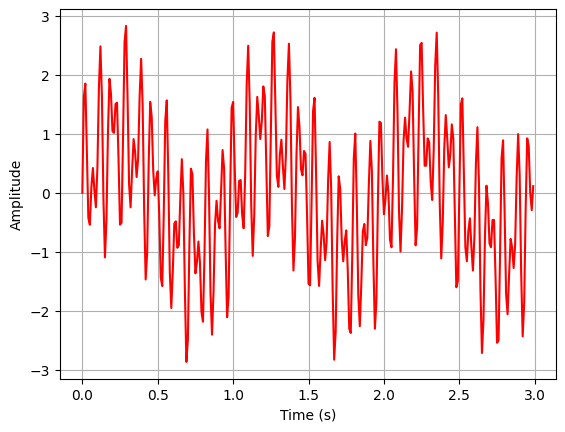

In [2]:
samp_rate = 100
samp_int = 1/samp_rate
t = np.arange(0,3,samp_int)
func = np.sin(2*np.pi*t) + np.sin(2*np.pi*11.2*t) + np.sin(2*np.pi*18.4*t)

plt.plot(t, func, 'r')
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel('Amplitude')
plt.show()

Since $x(t)$ is a continuous signal, we are only able to analyze it on a digital computer if we discretize it into some number of samples of $x(t)$ and analyze these instead. The plot above also only shows the first $3.0\text{ s}$ of our signal $x(t)$, which for all we know may continue far past this time for hours, years or even infinitely. A computer can obviously only process a finite number of samples, so to analyze this signal we must make an approximation and use a limited number of samples. To do this we will choose some finite duration sequence to represent the continuous time signal. Taking $1$ second of equally spaced samples yields the plot below.

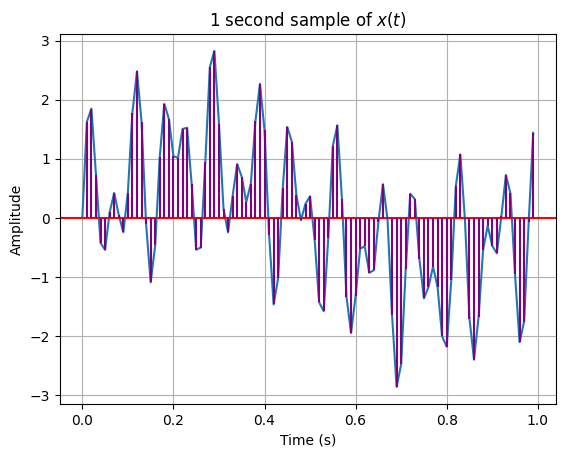

In [5]:
plt.plot(t[:samp_rate], func[:samp_rate])
plt.axhline(y=0, color='r')
plt.vlines(x = t[:samp_rate], ymin = 0, ymax = func[:samp_rate], color = 'purple')
plt.grid()
plt.title("$1$ second sample of $x(t)$")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

Applying the DFT where $x_j$ are the samples of $x$, we get the frequency amplitudes $\tilde{x}_k$ below.

In [6]:
def dft(x):
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    W = np.exp(2j * np.pi * k * n / N)
    X = np.dot(W, x)/(np.sqrt(N))
    return X

In [7]:
X = dft(func[:samp_rate])
#print("DFT coefficients X'(k):",X)

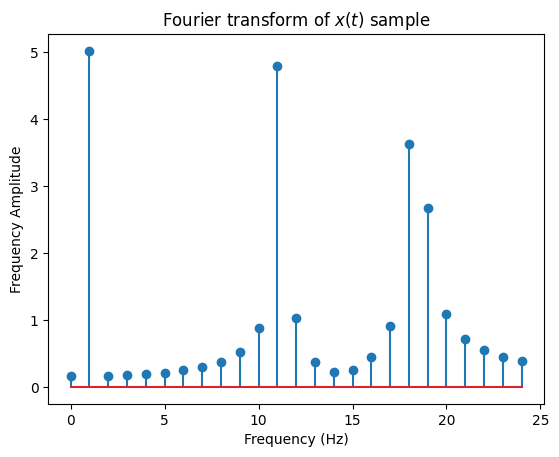

In [8]:
N=len(X)
n=np.arange(N)
T=N/samp_rate
freq = n/T
plt.stem(freq[:25],abs(X)[:25])
plt.title("Fourier transform of $x(t)$ sample")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency Amplitude")
plt.show()

Here we can see that the frequency amplitudes peak at the values $1, 11.2,$ and $18.4$, which are the frequencies composing $x(t)$. Suppose that the frequencies of a wave are given rather than its time-based representation. To construct the waveform composed of these frequencies, the inverse discrete Fourier transform (IDFT) can be applied. The inverse transform converts from the frequency domain to the time domain, allowing waveforms to be constructed from their frequencies. The IDFT takes as input the complex vector $\tilde{x}_k$ in the frequency basis and transforms it to the complex vector $x_j$ in the time basis defined by
$$x_j = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\tilde{x}_ke^{-2\pi i\frac{jk}{N}}.$$ 
Performing this transformation on the obtained frequency amplitudes, we obtain the reconstructed time signal sample below.

In [9]:
def inv_dft(x):
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    W = np.exp(-2j * np.pi * k * n / N)
    X = np.dot(x, W)/(np.sqrt(N))
    return X

C:\Users\Alexander Weiss\venv\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Alexander Weiss\venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


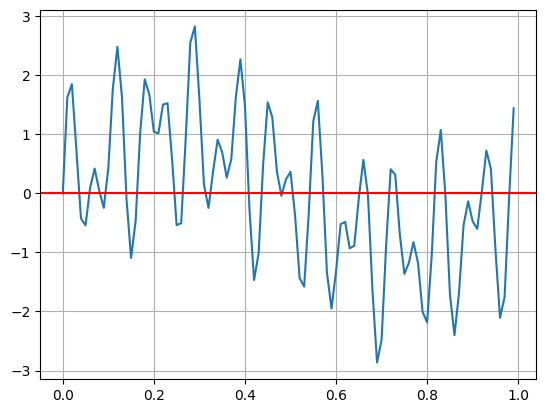

In [10]:
Y = inv_dft(X)
plt.plot(t[:samp_rate],Y)
plt.axhline(y=0, color='r')
plt.grid()
plt.show()

## Quantum Fourier Transform <a name="QFT"></a>

The quantum Fourier transform is functionally the same transformation as the DFT, however, instead of acting on a generic vector, it is explicitly applied to a quantum state vector. Let $j\in \mathbb{N}$ and $n$ be the number of qubits. The (forward) quantum Fourier transform (QFT) is defined as the map
$$|j\rangle 
\mapsto \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}e^{2\pi i\frac{jk}{2^n}}|k\rangle.$$
The QFT can be expressed using the unitary matrix
$$\text{QFT}_{n} = \frac{1}{\sqrt{2^n}}\sum_{j=0}^{2^n-1}\sum_{k=0}^{2^n-1}e^{2\pi i\frac{jk}{2^n}}|k\rangle \langle j|.$$

Since this is a linear system, QFT acting on a state $|x\rangle$ can be written as a matrix-vector multiplication, i.e.,
$$\text{QFT}_n|x\rangle 
= \begin{pmatrix}1 & 1 & 1 & \dots & 1 \\ 1 & \omega & \omega ^2 & \dots & \omega ^{2^n-1} \\ 1 & \omega ^2 & \omega ^4 & \dots & \omega^{2(2^n-1)} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & \omega ^{2^n-1} & \omega ^{2(2^n-1)} & \dots & \omega ^{(2^n-1)^2} \end{pmatrix} \begin{pmatrix}x_0\\ x_1\\ x_2\\ \vdots \\ x_{2^n-1} \end{pmatrix} 
= \begin{pmatrix}\tilde{x}_0\\ \tilde{x}_1\\ \tilde{x}_2\\ \vdots \\ \tilde{x}_{2^n-1} \end{pmatrix}$$
where $\omega = e^{2\pi i\frac{jk}{2^n}}$. This way it is very clear to see how the QFT is effectively a matrix transforming a vector of amplitudes. Conveniently, this is a unitary matrix and thus a valid quantum operator meaning a quantum algorithm can be constructed to implement this transformation.

With this matrix representation, we can easily visualize the QFT for any number of qubits:

$$\text{QFT}_n 
= \frac{1}{\sqrt{2^n}}\begin{pmatrix}1 & 1 & 1 & \dots & 1 \\ 1 & \omega & \omega ^2 & \dots & \omega ^{2^n-1} \\ 1 & \omega ^2 & \omega ^4 & \dots & \omega^{2(2^n-1)} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & \omega ^{2^n-1} & \omega ^{2(2^n-1)} & \dots & \omega ^{(2^n-1)^2} \end{pmatrix} \begin{pmatrix}x_0\\ x_1\\ x_2\\ \vdots \\ x_{2^n-1} \end{pmatrix}$$

$$\text{QFT}_0 
= \frac{1}{\sqrt{1}}\begin{pmatrix}1 \end{pmatrix} 
= \begin{pmatrix}1 \end{pmatrix}$$

$$\text{QFT}_1 
= \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \omega \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & e^{\frac{2\pi i}{N}} \end{pmatrix} 
= \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \cos(\frac{2\pi}{2}) + i \sin(\frac{2\pi}{2}) \end{pmatrix} 
= \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \cos(\pi) + i \sin(\pi) \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & -1 \end{pmatrix} 
= H$$

$% \text{QFT}_3 
% = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 & \omega & \omega ^2 \\ 1 & \omega ^2 & \omega ^4 \end{pmatrix} 
% = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 &  e^{\frac{2\pi i}{N}} &  e^{\frac{4\pi i}{N}} \\ 1 &  e^{\frac{4\pi i}{N}} &  e^{\frac{8\pi i}{N}} \end{pmatrix} 
% = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 &  \cos(\frac{2\pi}{3}) + i \sin(\frac{2\pi}{3}) &  \cos(\frac{4\pi}{3}) + i \sin(\frac{4\pi}{3}) \\ 1 & \cos(\frac{4\pi}{3}) + i \sin(\frac{4\pi}{3}) &  \cos(\frac{8\pi}{3}) + i \sin(\frac{8\pi}{3}) \end{pmatrix} 
% = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 & \frac{-1 + i\sqrt{3}}{2} & \frac{-1 - i\sqrt{3}}{2} \\ 1 & \frac{-1 - i\sqrt{3}}{2} &  \frac{-1 + i\sqrt{3}}{2} \end{pmatrix}$

$$\text{QFT}_3 = \frac{1}{\sqrt{8}}\begin{pmatrix}1 & 1 & 1 & 1 & 1 & 1 & 1 & 1\\ 1 & \omega & \omega ^2 & \omega ^3 & \omega ^4 & \omega ^5 & \omega ^6 & \omega ^7 \\ 1 & \omega ^2 & \omega ^4 & \omega ^6 & \omega ^8 & \omega ^{10} & \omega ^{12} & \omega ^{14} \\ 1 & \omega ^3 & \omega ^6 & \omega ^9 & \omega ^{12} & \omega ^{15} & \omega ^{18} & \omega ^{21} \\ 1 & \omega ^4 & \omega ^8 & \omega ^{12} & \omega ^{16} & \omega ^{20} & \omega ^{24} & \omega ^{28} \\ 1 & \omega ^5 & \omega ^{10} & \omega ^{15} & \omega ^{20} & \omega ^{25} & \omega ^{30} & \omega ^{35} \\ 1 & \omega ^6 & \omega ^{12} & \omega ^{18} & \omega ^{24} & \omega ^{30} & \omega ^{36} & \omega ^{42} \\ 1 & \omega ^7 & \omega ^{14} & \omega ^{21} & \omega ^{28} & \omega ^{35} & \omega ^{42} & \omega ^{49} \end{pmatrix} = \frac{1}{2\sqrt{2}}\begin{pmatrix}1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\ 1 & e^{\frac{\pi i}{4}} & e^{\frac{\pi i}{2}} & e^{\frac{3\pi i}{4}} & e^{\pi i} & e^{\frac{4\pi i}{4}} & e^{\frac{3\pi i}{2}} & e^{\frac{7\pi i}{4}} \\ 1 & e^{\frac{\pi i}{2}} & e^{\pi i} & e^{\frac{3\pi i}{2}} & e^{2\pi i} & e^{\frac{5\pi i}{2}} & e^{3\pi i} & e^{\frac{7\pi i}{2}} \\ 1 & e^{\frac{3\pi i}{4}} & e^{\frac{3\pi i}{2}} & e^{\frac{9\pi i}{4}} & e^{3\pi i} & e^{\frac{15\pi i}{4}} & e^{\frac{9\pi i}{2}} & e^{\frac{21\pi i}{4}} \\ 1 & e^{\pi i} & e^{2\pi i} & e^{3\pi i} & e^{4\pi i} & e^{5\pi i} & e^{6\pi i} & e^{\frac{35\pi i}{4}} \\ 1 & e^{\frac{3\pi i}{2}} & e^{3\pi i} & e^{\frac{9\pi i}{2}} & e^{6\pi i} & e^{\frac{15\pi i}{2}} & e^{9\pi i} & e^{\frac{21\pi i}{2}} \\ 1 & e^{\frac{7\pi i}{4}}& e^{\frac{7\pi i}{2}} & e^{\frac{21\pi i}{4}} & e^{7\pi i} & e^{\frac{35\pi i}{4}} & e^{\frac{21\pi i}{2}} & e^{\frac{49\pi i}{4}} \end{pmatrix}$$

$$ = \frac{1}{2\sqrt{2}}\begin{pmatrix}1 & 1 & 1 & 1 & 1 & 1 & 1 & 1\\ 1 & \frac{1+i}{\sqrt{2}} & i & \frac{-1+i}{\sqrt{2}} & -1 & \frac{-1-i}{\sqrt{2}} & -i & \frac{1-i}{\sqrt{2}} \\ 1 & i & -1 & -i & 1 & i & -1 & -i \\ 1 & \frac{-1+i}{\sqrt{2}} & -i & \frac{1+i}{\sqrt{2}} & -1 & \frac{1-i}{\sqrt{2}} & i & \frac{-1-i}{\sqrt{2}} \\ 1 & -1 & 1 & -1 & 1 & -1 & 1 & -1 \\ 1 & \frac{-1-i}{\sqrt{2}} & i & \frac{1-i}{\sqrt{2}} & -1 & \frac{1+i}{\sqrt{2}} & -i & \frac{-1+i}{\sqrt{2}} \\ 1 & -i & -1 & i & 1 & -i & -1 & i \\ 1 & \frac{1-i}{\sqrt{2}} & -i & \frac{-1-i}{\sqrt{2}} & -1 & \frac{-1+i}{\sqrt{2}} & i & \frac{1+i}{\sqrt{2}} \end{pmatrix} $$

Looking at the QFT for a single qubit when $n=1$, this is simply the Hadamard gate. As we know, this gate transforms the computational basis states $|0\rangle$ and $|1\rangle$ to the Fourier-basis states $|+\rangle$ and $|-\rangle$, respectively. Similarly, every multi-qubit state in the computational basis has a corresponding Fourier basis state. As mentioned above, the $\text{QFT}$ is just a transformation between these two bases. States in the Fourier basis are often denoted with a tilde (~). For example, the $\text{QFT}$ acting on the state $|x\rangle$ is notated as 

$$\text{QFT}|x\rangle = |\tilde{x}\rangle.$$

What about $\text{QFT}$ for large values of $n$? The QFT map can be rewritten using fractional binary notation where $k$ and $j$ are binary numbers, i.e.,
$$k=
k_1k_2\dots k_{n}.0 \ , 
\qquad 
j
=j_1j_2\dots j_{n}.0 \ .$$
Therefore, $\text{QFT}_n$ acting on a state $|j\rangle$ can be written as
$$\text{QFT}_n|j\rangle 
= \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1}e^{2\pi i\frac{jk}{2^n}}|k\rangle 
= \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1}e^{2\pi i \left(\sum_{l=1}^n k_l\frac{j}{2^{l}}\right)}|k\rangle 
= \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1}\prod_{l=1}^{n}e^{2\pi ik_l\frac{j}{2^{l}}}|k\rangle,$$
where
$$\frac{jk}{2^n} 
= k_1\frac{j}{2^1} + k_2\frac{j}{2^2} + \dots + k_{n}\frac{j}{2^n} 
= \sum_{l=1}^n k_l\frac{j}{2^{l}}.$$
Since $k$ is a binary number, each $k_n$ can only be $0$ or $1$. Thus the sum over $k$ becomes the direct product of the sum of each individual $k_n$ from $0$ to $1$, i.e.,
$$\text{QFT}_n|j\rangle 
= \frac{1}{\sqrt{2^n}} \sum_{k_1=0}^{1}e^{2\pi ik_1\frac{j}{2^{1}}}|k_1\rangle \otimes \sum_{k_2=0}^{1}e^{2\pi ik_2\frac{j}{2^{2}}}|k_2\rangle\otimes \cdots \otimes \sum_{k_n=0}^{1}e^{2\pi ik_n\frac{j}{2^{n}}}|k_n\rangle.$$
This can be rewritten as multiple tensor products, i.e.,
$$\text{QFT}_n|j\rangle 
= \frac{1}{\sqrt{2^n}}\bigotimes_{k=1}^{n}\left(|0\rangle + e^{2\pi i\frac{j}{2^{k}}}|1\rangle \right).$$

In order to really understand what is happening between these two bases, we can look at how different states in each basis is represented on the Bloch sphere. The .gif's in $\text{Fig. }1$ and $\text{Fig. }2$ are taken from the Qiskit notebook on the QFT and show very clearly how a number in the computational and Fourier bases are represented with 4 qubits. In the computational basis, we can see that the leftmost qubit has the highest "flipping" frequency where it flips with every step up. The second qubit, qubit $1$, flips twice as frequently as qubit $0$, and the next twice as much as that and the pattern continues. So any subsequent qubit in the computational basis will have double the frequency as the qubit before it and so on. 

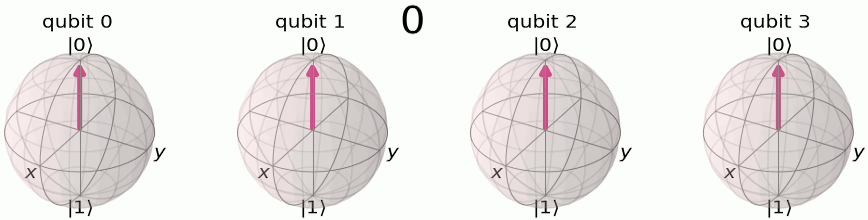

$$\textbf{Fig. }1:\text{ Counting in Computational Basis}$$

Looking at how we count in the Fourier basis in $\text{Fig. }2$, we can see that each number is instead represented as a rotation around the $Z$-axis. Starting with the $|\tilde{0}\rangle$ state, every qubit is in the $|+\rangle$ state. Each number in the Fourier basis tells us exactly how many turns the leftmost qubit makes around the $Z$-axis by the formula $\frac{a}{2^n}$ where $a$ is the number we want to store and $n$ is again the number of qubits. For example, to encode the state $|\tilde{7}\rangle$ on $4$ qubits as shown in $\text{Fig. }2$, we simply do $\frac{a}{2^n} = \frac{7}{2^4} = \frac{7}{16}$ full turns around the $Z$-axis which is equivalent to $2\pi\times\frac{7}{16} = \frac{7\pi}{8}$ because $2\pi \equiv \text{One Full Rotation}$. The next qubit is rotated twice as much as the previous $(2\times \frac{7\pi}{8} = \frac{7\pi}{4})$ and so on for all subsequent qubits. In the Fourier basis, the leftmost qubit now has the lowest frequency whereas in the computational basis the leftmost qubit had the highest.

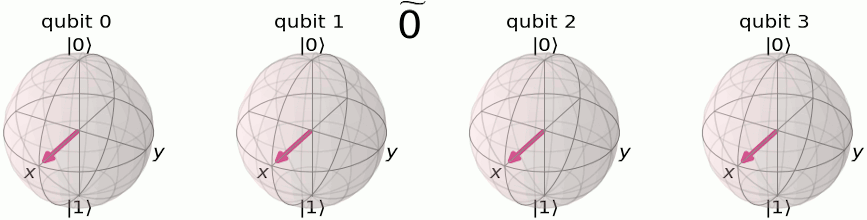

$$\textbf{Fig. }2:\text{ Counting in Fourier Basis}$$

### Proof <a name="proof"></a>

If the circuit in $\text{Fig. }\#$ performs a Fourier transform, then the final state of the circuit is written the same as above $%ref$. If this is true, then removing the swap gates will swap the qubit order of the output. This implies that the final state would be
$$\overset{\longleftarrow}{\text{QFT}}_n|j\rangle 
= \frac{1}{\sqrt{2^n}}\bigotimes_{k=n}^{1}\left(|0\rangle + e^{2\pi i\frac{j}{2^{k}}}|1\rangle \right),$$
which we will call the swap-less QFT circuit.

Using the swap-less QFT circuit and the equation above, we construct an inductive proof verifying the circuit in $\text{Fig. }\#$ does indeed perform a Fourier transform. Consider the swap-less QFT circuit with a single qubit. Here, the circuit becomes a single $R_1$ gate which is equivalent to a Hadamard gate. According to the above equation, the initial state of the qubit transforms to,
$$\overset{\longleftarrow}{\text{QFT}}_1|j\rangle 
= \frac{1}{\sqrt{2^1}}\bigotimes_{k=1}^{1}\left(|0\rangle + e^{2\pi i\frac{j}{2^{k}}}|1\rangle \right) 
= \frac{1}{\sqrt{2}}\left(|0\rangle + e^{2 \pi i 0.j_0}|1\rangle \right),$$
where if $j=0$,
$$\overset{\longleftarrow}{\text{QFT}}_1|0\rangle 
= \frac{1}{\sqrt{2}}\left(|0\rangle + e^{0}|1\rangle \right) 
= \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right) 
= |+\rangle,$$
and if $j=1$,
$$\overset{\longleftarrow}{\text{QFT}}_1|1\rangle 
= \frac{1}{\sqrt{2}}\left(|0\rangle + e^{\pi i}|1\rangle \right) 
= \frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle \right) 
= |-\rangle.$$
Since this is exactly the effect of a Hadamard gate, when $n=1$, the swap-less QFT circuit correctly perform the map above.
        
Since $\overset{\longleftarrow}{\text{QFT}}_n$ represents the swap-less QFT circuit for n qubits, it then follows that $\overset{\longleftarrow}{\text{QFT}}_{n+1}$ can be written as
$$\overset{\longleftarrow}{\text{QFT}}_{n+1}|j\rangle 
= \frac{1}{\sqrt{2}}\left(|0\rangle + e^{2 \pi i 0.j_0\dots j_{n}}|1\rangle \right) \otimes \overset{\longleftarrow}{\text{QFT}}_n|j_1 \dots j_{n}\rangle. $$
From the inductive hypothesis, the $\overset{\longleftarrow}{\text{QFT}}_n|j_1 \dots j_{n+1}\rangle$ part of the $\overset{\longleftarrow}{\text{QFT}}_{n+1}$ is correctly performing the map. Therefore, if the first bit is being transformed correctly, the entire mapping is correct. The phase on the $|1\rangle$ state in the equation above can be rewritten as a combination of rotations specific to each binary digit of $j$, i.e.,
$$e^{2 \pi i 0.j_0\dots j_{n}} 
= e^{2 \pi i \frac{j_0}{2^1}} e^{2 \pi i \frac{j_1}{2^2}}\cdots e^{2 \pi i \frac{j_{n}}{2^{n+1}}} = e^{j_0 \left(\pi i\right) } e^{j_1 \left(\frac{\pi i}{2}\right)}\cdots e^{j_{n} \left(\frac{\pi i}{2^n}\right) }.$$
Since the phase rotation can be rewritten as a product of rotations that are dependant only on a single qubit, each rotation can be directly converted to a single controlled rotation gate. The rotation for each of these gates is defined as
$$r_n 
= \frac{\pi}{2^{n}}
$$
where $n$ represents the qubit's number. Upon inspecting $\overset{\longleftarrow}{\text{QFT}}_{n+1}$, the gates defined here and in \cref{prop:QFT} are equivalent. This means that if the swap-less QFT circuit with $n$ qubits performs the map $\overset{\longleftarrow}{\text{QFT}}_n$, the swap-less QFT circuit with $n+1$ qubits performs the map $\overset{\longleftarrow}{\text{QFT}}_{n+1}$. Therefore, by induction the swap-less QFT circuit performs the map $\overset{\longleftarrow}{\text{QFT}}_n$ for all $n \geq 1$.
        
Since the swap-less QFT performs the mapping $\overset{\longleftarrow}{\text{QFT}}_n$, the circuit in $\text{Fig. }\#$ must perform the mapping in \cref{def:qft}.

### Example <a name="example"></a>

Before using the algorithm to convert to and from the Fourier basis, it is important to understand how to write an algorithm like this independently.

To start, lets try to find a pattern which we can use to construct a circuit. Suppose we wanted to transform a single qubit into the Fourier basis. Using the tensor product definition for the final states of a $QFT$ gives us the equation:

$$QFT_1|j\rangle 
= \frac{1}{\sqrt{2^n}}\bigotimes_{n = 1}^{1}\left(|0\rangle +e^{\frac{2\pi i}{2^n} j}|1\rangle \right) 
= \frac{1}{\sqrt{2^1}}\left(|0\rangle +e^{\frac{2\pi i}{2^1} j}|1\rangle \right) 
= \frac{1}{\sqrt{2}}\left(|0\rangle +e^{j \pi i}|1\rangle \right) $$

$$QFT_1|0\rangle 
= \frac{1}{\sqrt{2}}\left(|0\rangle +e^{0}|1\rangle \right) 
= \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right) 
= |+\rangle$$

$$QFT_1|1\rangle 
= \frac{1}{\sqrt{2}}\left(|0\rangle +e^{\pi i}|1\rangle \right) 
= \frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle \right) 
= |-\rangle$$

Like we saw before, this means that QFT acting on the first qubit is equivalent to a Hadamard Gate.

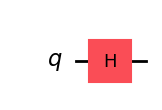

In [3]:
qft_example = QuantumCircuit(1)
qft_example.h(0)
qft_example.draw('mpl')

Suppose now we wanted to do a Fourier transform with two qubits instead of one. Let $S$ be the decimal$%binary?$ number that represents the state the $QFT$ is being applied to. This means that $S = q_0 2^0 + q_1 2^1 = q_0 + 2q_1$ for two qubits. So $QFT$ acting on $2$ qubits is

$$QFT_2|q_0q_1\rangle = \frac{1}{\sqrt{2^2}}\bigotimes_{n=1}^{2}\left(|0\rangle +e^{\frac{2\pi i}{2^n} S}|1\rangle \right)= \frac{1}{\sqrt{2}}\left(|0\rangle + e^{\frac{2\pi i}{2^1} S}|1\rangle \right) \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{\frac{2\pi i}{2^2} S}|1\rangle \right) = \frac{1}{\sqrt{2}}\left(|0\rangle + e^{\pi i S}|1\rangle \right) \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{\frac{\pi i}{2} S}|1\rangle \right).$$

Subtituting in $S = q_0 + 2q_1$,

$$QFT_2|q_0q_1\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + e^{q_0\pi i}e^{q_1 2\pi i}|1\rangle \right) \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{q_0\frac{\pi i}{2}} e^{q_1 \pi i}|1\rangle \right) = \frac{1}{\sqrt{2}}\left(|0\rangle + e^{q_0\pi i}|1\rangle \right) \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{q_0\frac{\pi i}{2}} e^{q_1 \pi i}|1\rangle \right).$$

The state can be rewritten using $QFT_1$ as

$$QFT_2|q_0q_1\rangle = QFT_1|q_0\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{q_0\frac{\pi i}{2}} e^{q_1 \pi i}|1\rangle \right).$$

Suppose $q_0 = 0$, then the state becomes

$$QFT_2|0q_1\rangle = QFT_1|0\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle + e^{q_1 \pi i}|1\rangle \right).$$

If $q_1 = 0$, then $q_1$ goes from the $|0\rangle$ state to the $|+\rangle$ state after the transformation. If $q_1=1$ then $q_1$ goes from the $|1\rangle$ state to the $|-\rangle$ state after the transformation. This means we must apply a Hadamard gate to $q_1$.

Suppose now $q_1 = 0$, the state then becomes

$$QFT_2|q_00\rangle = QFT_1|q_0\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle + e^{q_0\frac{\pi i}{2}}|1\rangle \right).$$

If $q_0=0$, then $q_1$ goes from the $|0\rangle$ state to the $|+\rangle$ state after the transformation. If $q_0=1$, then the $|1\rangle$ part of the $q_1$ state rotates by $\frac{\pi}{2}\text{ rad}$. This can be added to the circuit with a controlled phase gate. The phase gate is defined as
$$P(\theta) 
= \begin{pmatrix}1 & 0 \\
0 & e^{i\theta}\end{pmatrix}.$$
So applying this gate to a superposition of $|0\rangle$ and $|1\rangle$ will rotate the $|1\rangle$ state by $\theta$. Therefore, by applying a controlled phase gate to $q_1$ controlled on $q_0$ where $\theta = \frac{\pi}{2}$, the $|1\rangle$ part of the state of $q_1$ will rotate by $\frac{\pi}{2} \text{ rad}$ only in the case that $q_0 = 1$.

In [4]:
num = 1

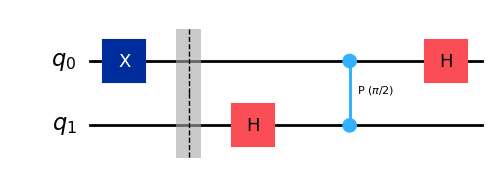

In [5]:
qft_example = QuantumCircuit(2)
if num==1:
    qft_example.x(0)
if num==2:
    qft_example.x(1)
if num==3:
    qft_example.x(0)
    qft_example.x(1)
qft_example.barrier()
qft_example.h(1)
qft_example.cp(pi/2, 0, 1)
qft_example.h(0)
qft_example.draw('mpl')

Now that the circuit has been constructed, lets look at the resulting statevector where $q_0 = 1$ and $q_1 = 0$ on the bloch sphere and compare it to what we expect.

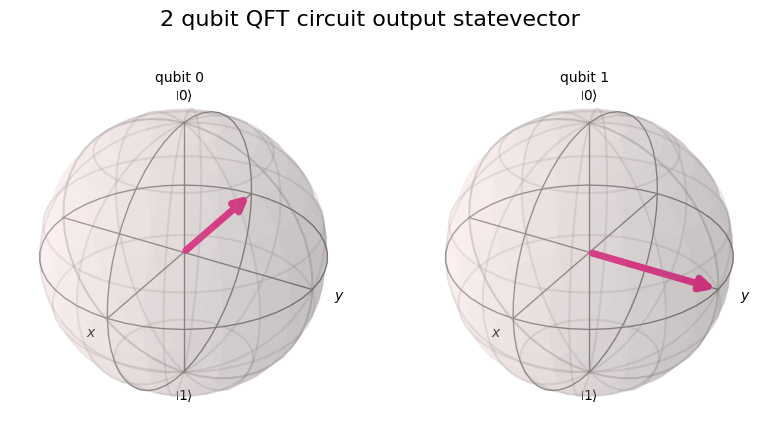

In [7]:
sv = Statevector(qft_example)
plot_bloch_multivector(qft_example, title = '2 qubit QFT circuit output statevector')

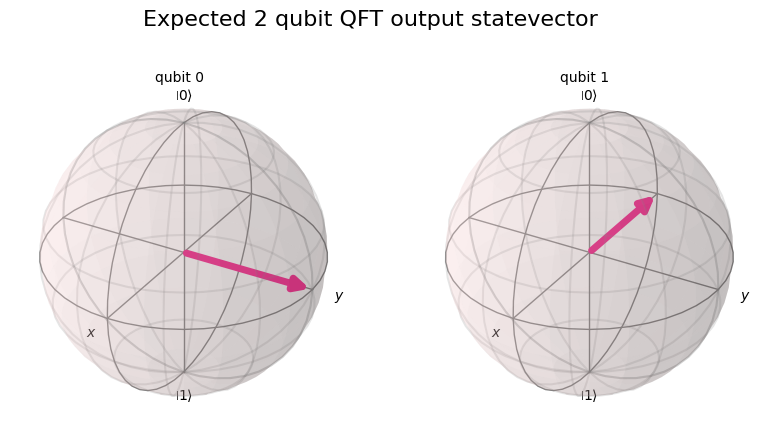

In [8]:
qft_example_check = QuantumCircuit(2)
for i in range(2):
    qft_example_check.h(i)
    qft_example_check.p(2*pi/2**(2-i)*num, i)
sv = Statevector(qft_example_check)
plot_bloch_multivector(qft_example_check, title = 'Expected 2 qubit QFT output statevector')

Looking at the two different sets of Bloch spheres, it appears that the order of the qubits is opposite to what we expect. This can be easily resolved by implementing a swap gate to the end of our circuit.

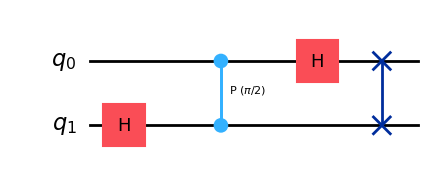

In [9]:
qft_example = QuantumCircuit(2)
# qft_example.x(0)
# qft_example.x(1)
qft_example.h(1)
qft_example.cp(pi/2, 0, 1)
qft_example.h(0)
qft_example.swap(0,1)
qft_example.draw('mpl')

Now that we know how to transform the first 2 qubits, what happens if we try to transform the third?
Let $S = q_0 2^0 + q_1 2^1 + q_2 2^2 = q_0 + 2q_1 + 4q_2$ since there are now 3 qubits. $QFT$ acting on $3$ qubits is

$$QFT_3|q_0q_1q_2\rangle = \frac{1}{\sqrt{2^3}}\bigotimes_{n=1}^{3}\left(|0\rangle +e^{\frac{2\pi i}{2^n} S}|1\rangle \right) =
\frac{1}{\sqrt{2}}\left(|0\rangle +e^{\pi i S}|1\rangle \right) \otimes 
\frac{1}{\sqrt{2}}\left(|0\rangle +e^{\frac{\pi i}{2} S}|1\rangle \right) \otimes 
\frac{1}{\sqrt{2}}\left(|0\rangle +e^{\frac{\pi i}{4} S}|1\rangle \right).$$

This can be rewritten using $QFT_2$ as

$$QFT_3|q_0q_1q_2\rangle = QFT_2|q_0q_1\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{\frac{\pi i}{4} S}|1\rangle \right).$$

Substituting in $S = q_0 + 2q_1 + 4q_2$, the state becomes

$$QFT_3|q_0q_1q_2\rangle=  QFT_2|q_0q_1\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle + e^{\frac{\pi i}{4} q_0}e^{\frac{\pi i}{4} q_1(2)}e^{\frac{\pi i}{4} q_2(4)}|1\rangle \right) = QFT_2|q_0q_1\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle + e^{q_0 \frac{\pi i}{4} }e^{q_1\frac{\pi i}{2} }e^{q_2\pi i }|1\rangle \right).$$

So to transform $q_2$ into the fourier basis, we must apply a rotation of $\frac{\pi}{4} \text{ rad}$ if and only if $q_0 = 1$, $\frac{\pi}{2} \text{ rad}$ if and only if $q_1 = 1$, and $\pi \text{ rad}$ if and only if $q_2 = 1$ to the $|1\rangle$ part of $q_2$. These transforms can easily be done with controlled phase operations and one Hadamard gate.

In [10]:
num=3

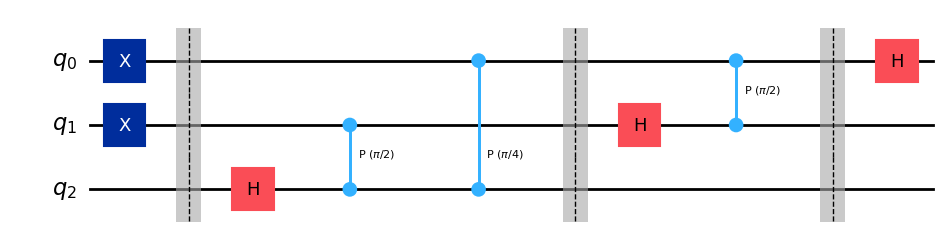

In [11]:
qft_example = QuantumCircuit(3)
if num%2==1: # checks to see if the number is odd
    qft_example.x(0)
if int(num/2%2)==1: # checks to see if there's a one in the second binary digit
    qft_example.x(1)
if int(num/2**2%2)==1: # checks to see if there's a one in the third binary digit
    qft_example.x(2)
qft_example.barrier()
qft_example.h(2)
qft_example.cp(pi/2, 1, 2)
qft_example.cp(pi/4, 0, 2)
qft_example.barrier()
qft_example.h(1)
qft_example.cp(pi/2, 0, 1)
qft_example.barrier()
qft_example.h(0)
qft_example.draw('mpl')

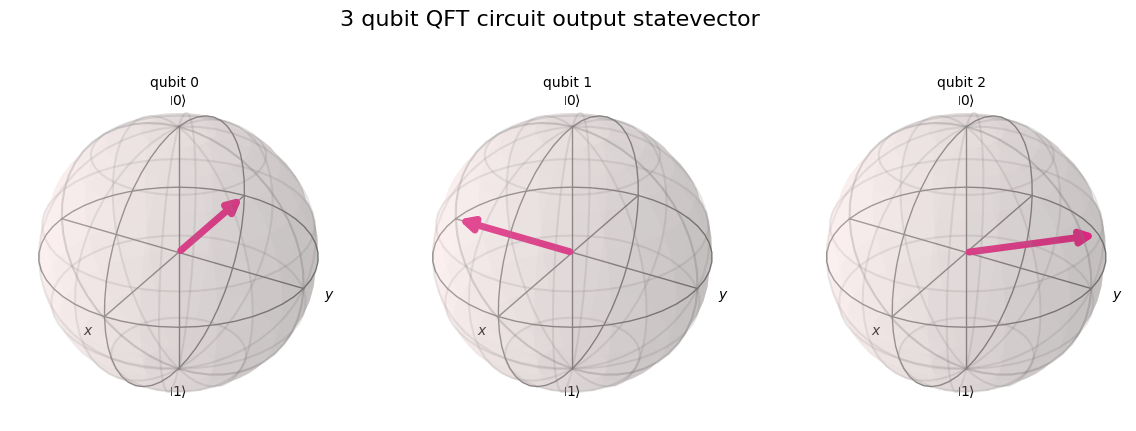

In [12]:
sv = Statevector(qft_example)
plot_bloch_multivector(qft_example, title = '3 qubit QFT circuit output statevector')

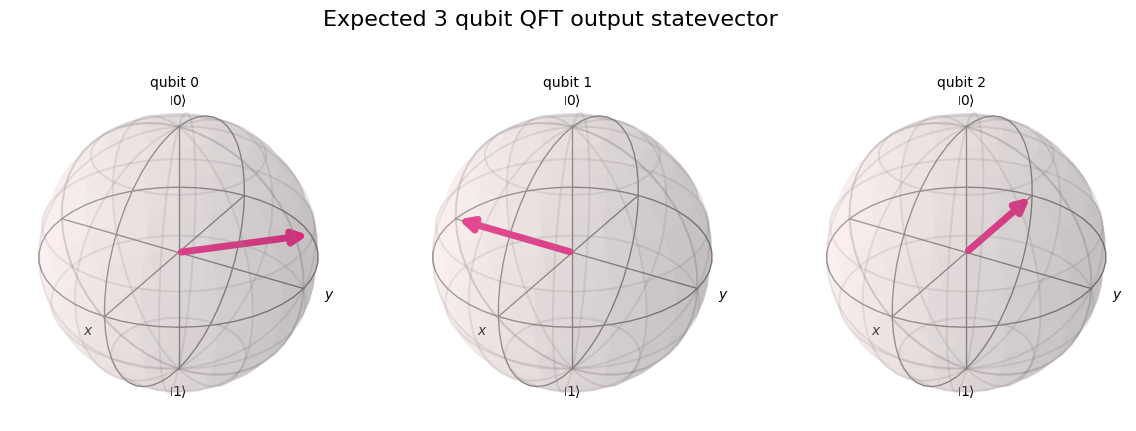

In [13]:
qft_example_check = QuantumCircuit(3)
for i in range(3):
    qft_example_check.h(i)
    qft_example_check.p(2*pi/2**(3-i)*num, i)
sv = Statevector(qft_example_check)
plot_bloch_multivector(qft_example_check, title = 'Expected 3 qubit QFT output statevector')

Again it appears that the qubit are in reverse order, thus we still need the swap gate.

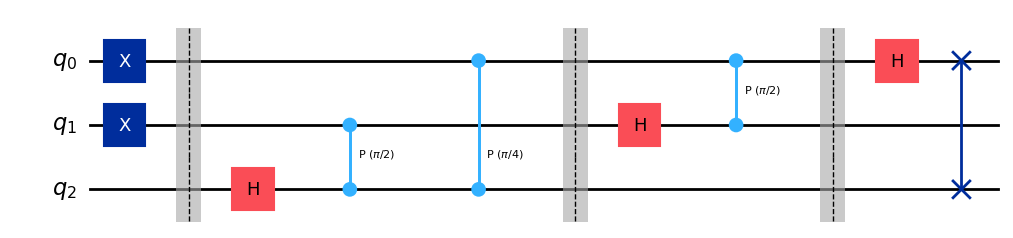

In [14]:
qft_example = QuantumCircuit(3)
if num%2==1: # checks to see if the number is odd
    qft_example.x(0)
if int(num/2%2)==1: # checks to see if there's a one in the second binary digit
    qft_example.x(1)
if int(num/2**2%2)==1: # checks to see if there's a one in the third binary digit
    qft_example.x(2)
qft_example.barrier()
qft_example.h(2)
qft_example.cp(pi/2, 1, 2)
qft_example.cp(pi/4, 0, 2)
qft_example.barrier()
qft_example.h(1)
qft_example.cp(pi/2, 0, 1)
qft_example.barrier()
qft_example.h(0)
qft_example.swap(0,2)
qft_example.draw('mpl')

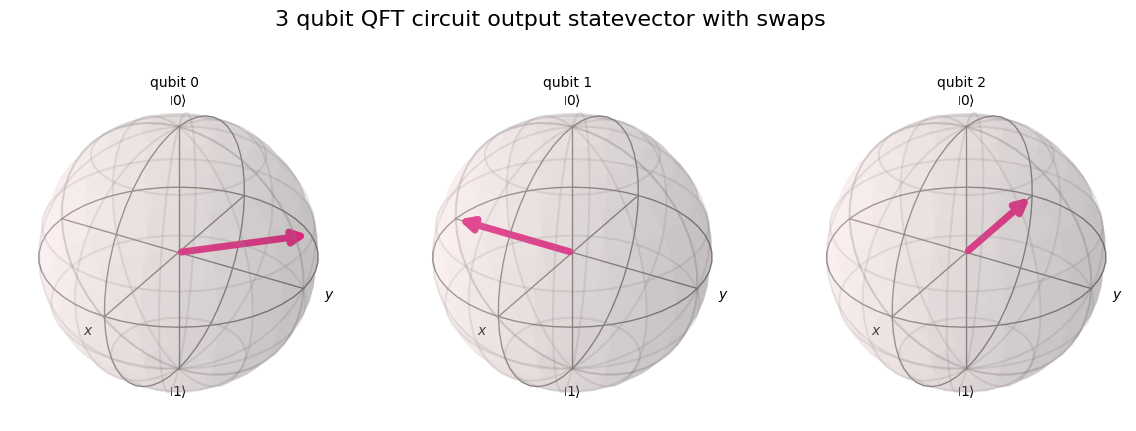

In [15]:
sv = Statevector(qft_example)
plot_bloch_multivector(qft_example, title = '3 qubit QFT circuit output statevector with swaps')

The pattern that follows from these examples is:

$$QFT_n|q_0 \cdots q_{n-1}\rangle =  QFT_{n-1}|q_0 \cdots q_{n-2}\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle + e^{\frac{\pi i}{2^{n - 1}} q_0}e^{\frac{\pi i}{2^{n-2}} q_1} \cdots e^{\pi i q_{n-1}}|1\rangle \right)$$

This means to tranform $q_n$, we can apply a Hadamard gate to a single qubit, then apply a controlled phase gate for each qubit with rotation $\frac{2\pi}{2^{n - m}}$ where $m$ is the number of the control qubit. Then the order of the qubits must be reversed, which can be done with swap gates.
 
Now that we have constructed a procedure for an $n$- dimensional $\text{QFT}$, we can transfer this procedure into a for loop to make any size $\text{QFT}$ circuit.

In [52]:
def badd_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(qubits):
        highest = qubits-i-1
        print(highest)
        if show_steps: print("\nPerforming Fourier transform on qubit", highest)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest)
        for j in range(highest):
            qubit = highest-j-1
            if show_steps: print("\tControl Phase π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp((pi)/2**(highest-qubit), qubit, highest)
        circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    if show_steps: print("\nCompleted transformation\n")

In [189]:
def add_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    highest = qubits - 1
    for i in range(qubits):
        tgt = highest - i
        circuit.h(tgt)
        for j in range(tgt + 1):
            qubit = tgt - j
            if qubit != tgt:
                circuit.cp((pi)/(2**(tgt - qubit)), qubit, tgt)
        circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    if show_steps: print("\nCompleted transformation\n")

In [190]:
num = 11
bits = 6

In [191]:
binary_num = bin(num)[2:]
if len(binary_num)>bits: bits = len(binary_num)
print("Number (base10):", num)
print("Number (base2):", binary_num)
print("Number of bits:", bits)
expected_output = list(binary_num)
for i in range (bits-len(binary_num)):
    expected_output.insert(0,'0')
for i in range(int(len(expected_output)/2)):
    j = len(expected_output)-i-1
    temp = expected_output[i]
    expected_output[i] = expected_output[j]
    expected_output[j] = temp
print("Converted Input for Circuit:","".join(expected_output))

Number (base10): 11
Number (base2): 1011
Number of bits: 6
Converted Input for Circuit: 110100


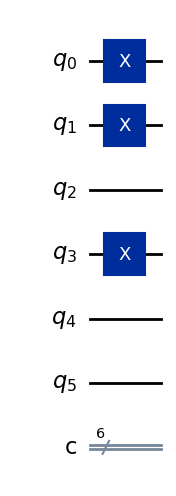

In [192]:
qc = QuantumCircuit(bits,bits)
for i in range(len(binary_num)):
    if int(expected_output[i]) == 1:
        qc.x(i)
qc.draw('mpl')

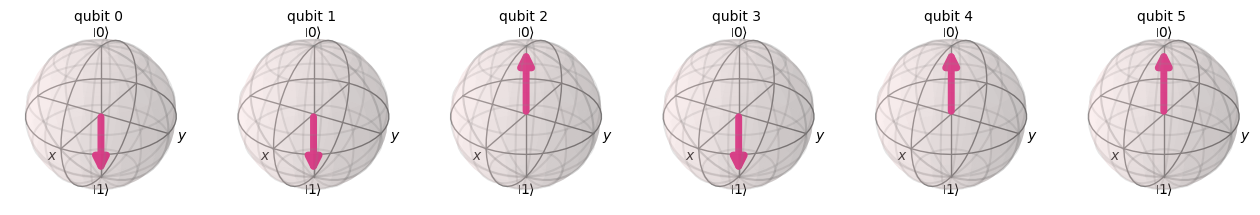

In [193]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

After intitalizing the qubits, we then need to perform a Fourier transform. To do this you need 

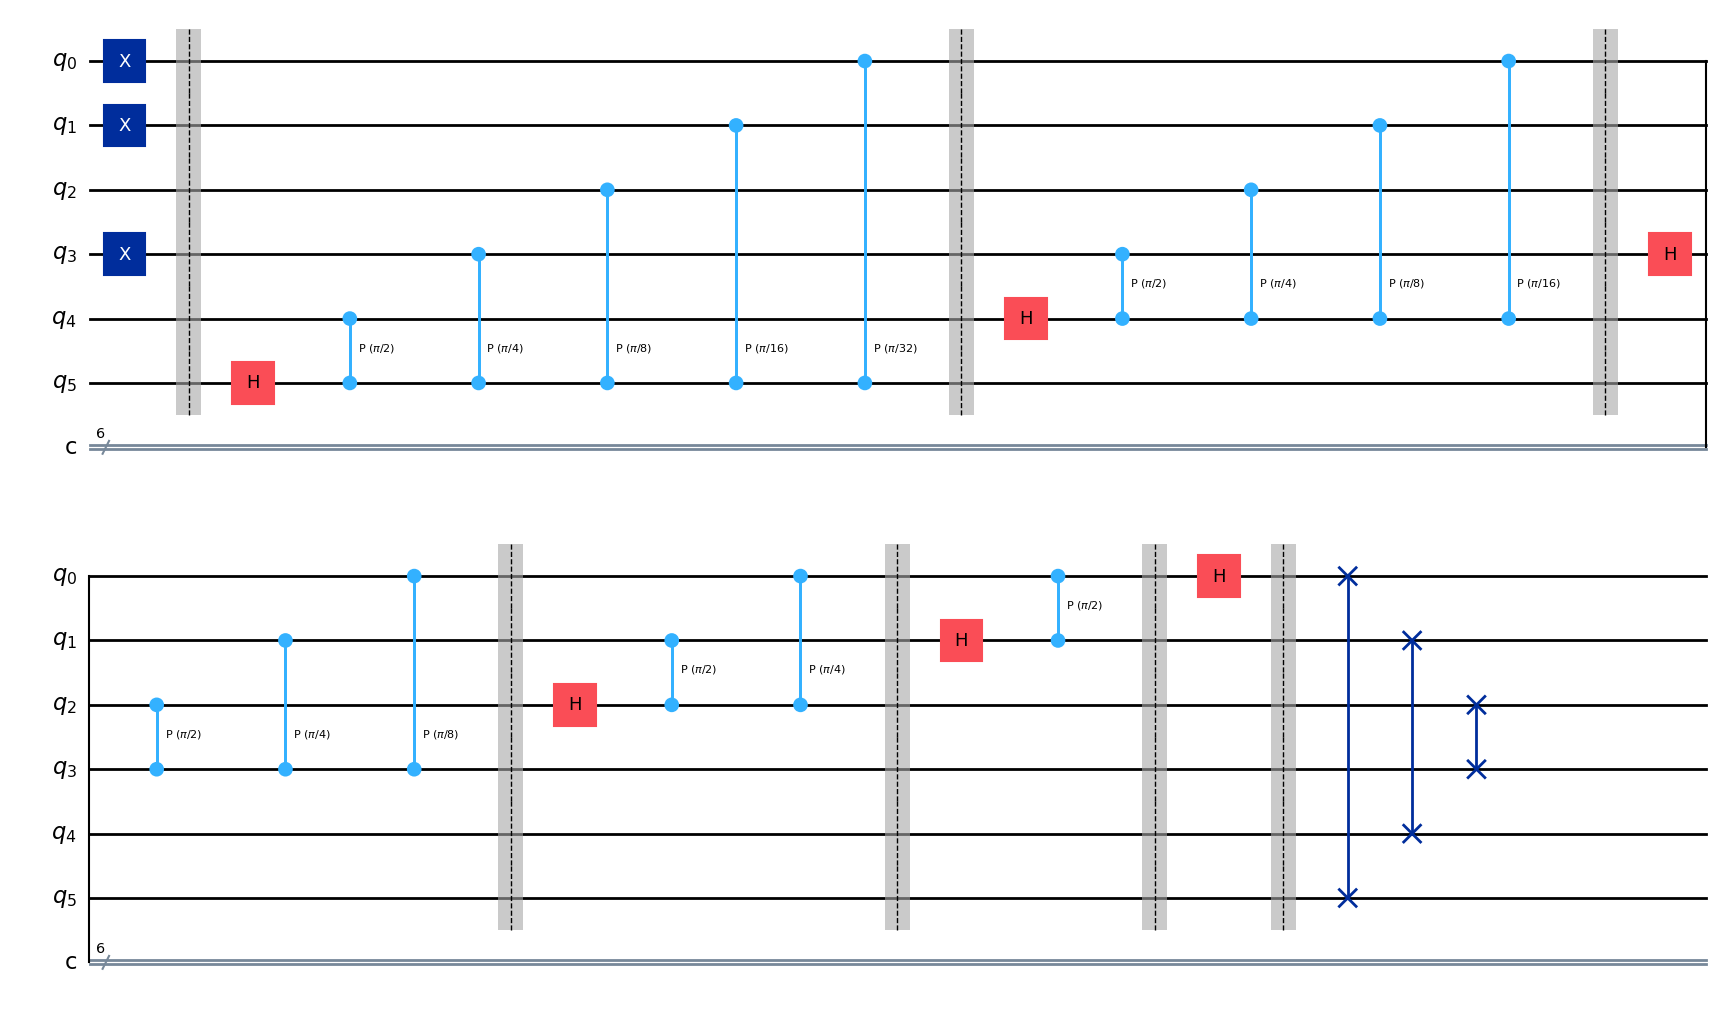

In [194]:
add_fourier_transform(qc, bits)
qc.draw('mpl')

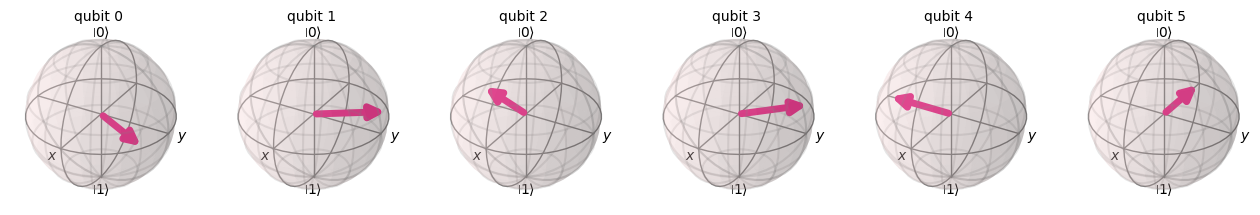

In [195]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

Lets compare our result with the expected result for the transform.

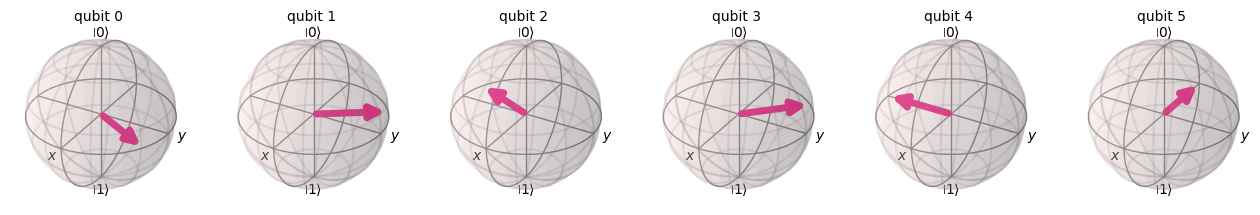

In [196]:
qc = QuantumCircuit(bits,bits)
for i in range(len(expected_output)):
    qc.h(i)
    qc.p(2*pi/2**(len(expected_output)-i) * num, i)
sv = Statevector(qc)
plot_bloch_multivector(sv)

Now that we can transform into the Fourier Basis, we can use it to do more complex calculations in much fewer steps. After the calculations are done, we need to convert the statevector back into something that a quantum computer can read. To do this we need to do an inverse Fourier transform. Since the Fourier basis matrix is a valid quantum gate, the inverse of it is equivent to the Hermitian of that matrix.

$$QFT_{n}^\dagger|q_0 \cdots q_{n-1}\rangle =  QFT_{n-1}^\dagger|q_0 \cdots q_{n-2}\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle + e^{\frac{-\pi i}{2^{n - 1}} q_0}e^{\frac{-\pi i}{2^{n-2}} q_1} \cdots e^{-\pi i q_{n-1}}|1\rangle \right)$$

This is equivent to applying a Hadamard gate on $q_n$ then applying a controlled phase gate for each qubit with rotation $\frac{-\pi}{2^{n-m}}$ where $m$ is the number of the control qubit. Since we had to swap the output of our Fourier Transform, we must do the same at the end of the inverse of the transform as well to return the correct value.

In [197]:
def add_inv_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    for highest in range(qubits):
        if show_steps: print("\nPreforming inverse transform on qubit", highest)
        circuit.barrier()
        for qubit in range(highest):
            # qubit = highest-j-1
            if show_steps: print("\tControl Phase -π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp((-pi)/2**(highest-qubit), highest, qubit)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest) 
    if show_steps: print("\nCompleted transformation\n")

In [198]:
num = 11
bits = 6

In [199]:
binary_num = bin(num)[2:]
if len(binary_num)>bits: bits = len(binary_num)
print("Number (base10):", num)
print("Number (base2):", binary_num)
print("Number of bits:", bits)
expected_output = list(binary_num)
for i in range (bits-len(binary_num)):
    expected_output.insert(0,'0')
for i in range(int(len(expected_output)/2)):
    j = len(expected_output)-i-1
    temp = expected_output[i]
    expected_output[i] = expected_output[j]
    expected_output[j] = temp
print("Expected Output from Circuit:","".join(expected_output))

Number (base10): 11
Number (base2): 1011
Number of bits: 6
Expected Output from Circuit: 110100


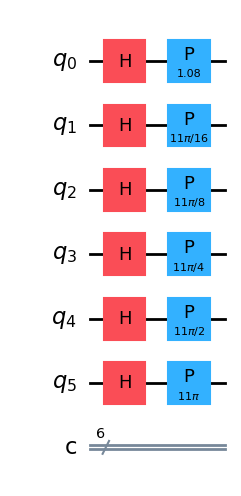

In [200]:
qc = QuantumCircuit(bits,bits)
for i in range(len(expected_output)):
    qc.h(i)
    qc.p(2*pi/2**(len(expected_output)-i) * num, i)
qc.draw('mpl')

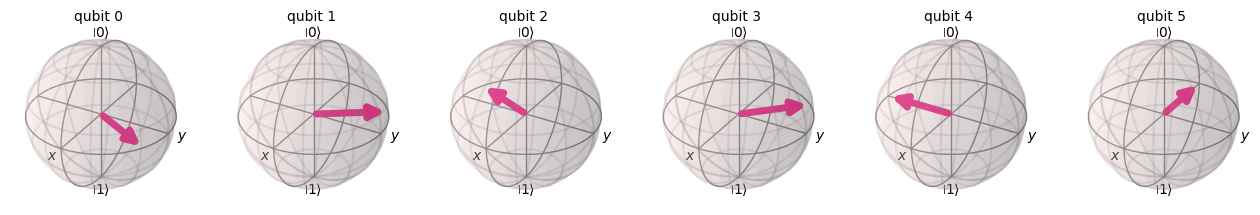

In [201]:
sv = Statevector(qc)
plot_bloch_multivector(sv)


Preforming inverse transform on qubit 0
	Adding H gate to qubit 0

Preforming inverse transform on qubit 1
	Control Phase -π/2^1 gate applied to 1 using qubit 0 as control
	Adding H gate to qubit 1

Preforming inverse transform on qubit 2
	Control Phase -π/2^2 gate applied to 2 using qubit 0 as control
	Control Phase -π/2^1 gate applied to 2 using qubit 1 as control
	Adding H gate to qubit 2

Preforming inverse transform on qubit 3
	Control Phase -π/2^3 gate applied to 3 using qubit 0 as control
	Control Phase -π/2^2 gate applied to 3 using qubit 1 as control
	Control Phase -π/2^1 gate applied to 3 using qubit 2 as control
	Adding H gate to qubit 3

Preforming inverse transform on qubit 4
	Control Phase -π/2^4 gate applied to 4 using qubit 0 as control
	Control Phase -π/2^3 gate applied to 4 using qubit 1 as control
	Control Phase -π/2^2 gate applied to 4 using qubit 2 as control
	Control Phase -π/2^1 gate applied to 4 using qubit 3 as control
	Adding H gate to qubit 4

Preforming inv

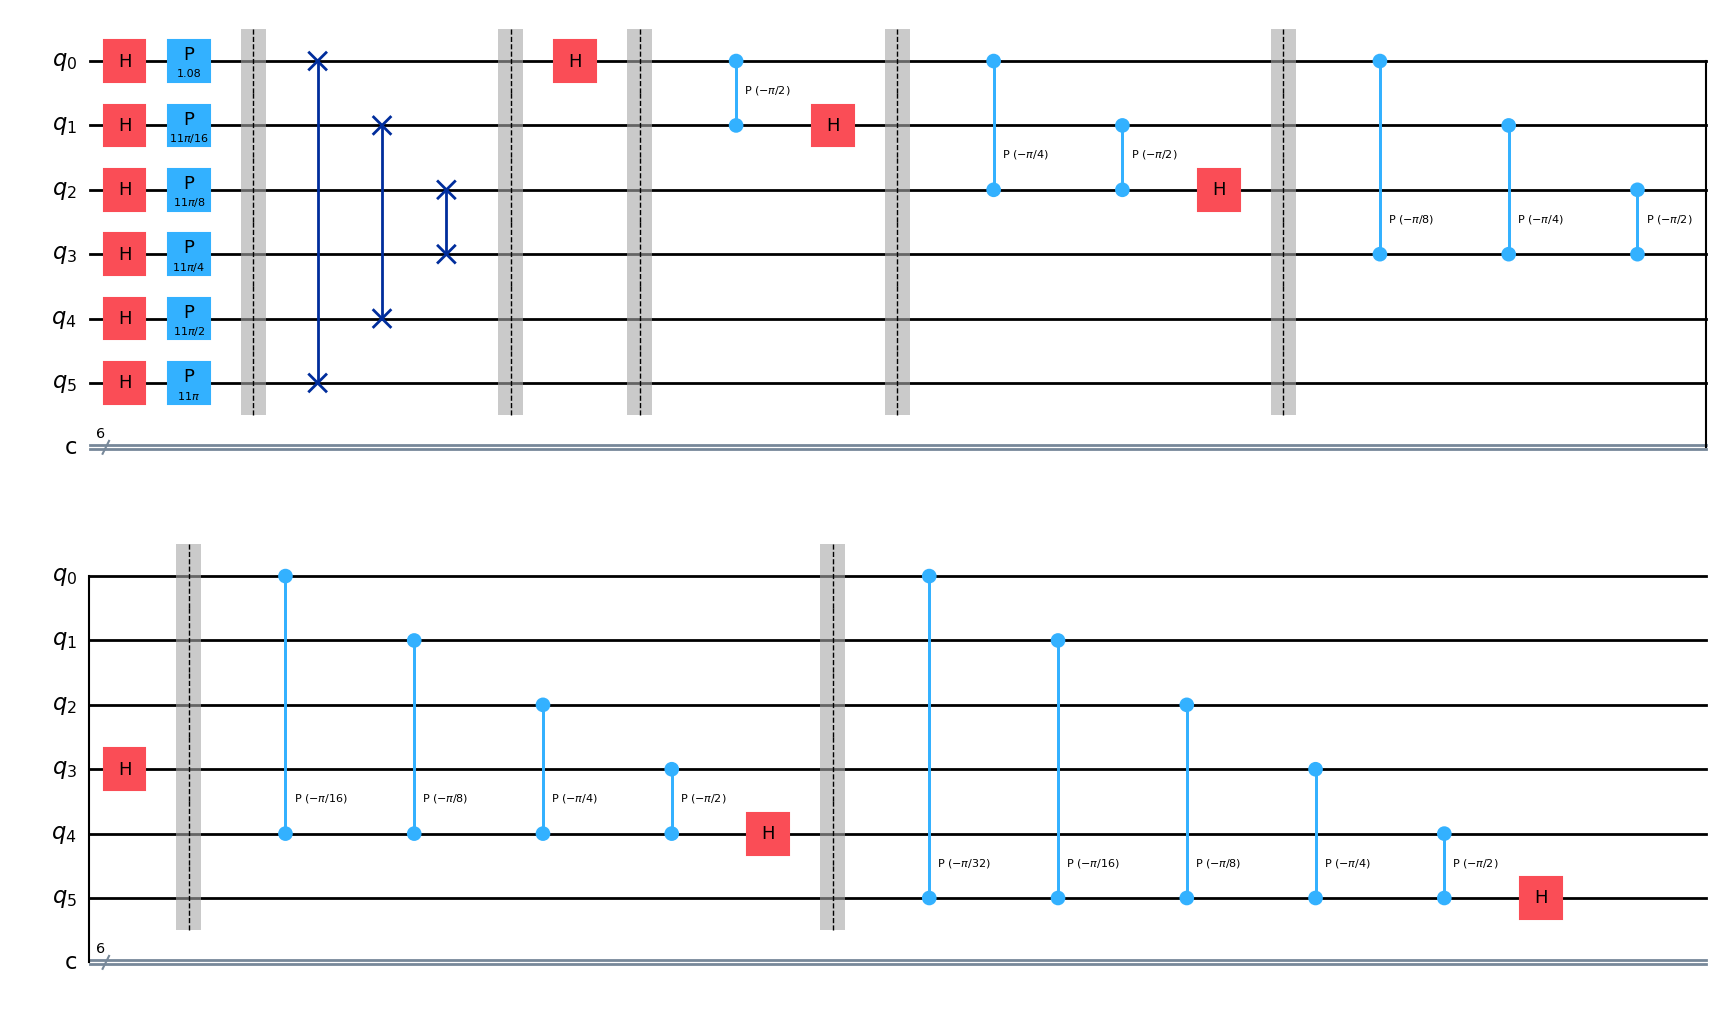

In [202]:
add_inv_fourier_transform(qc, bits, show_steps = True)
qc.draw('mpl')

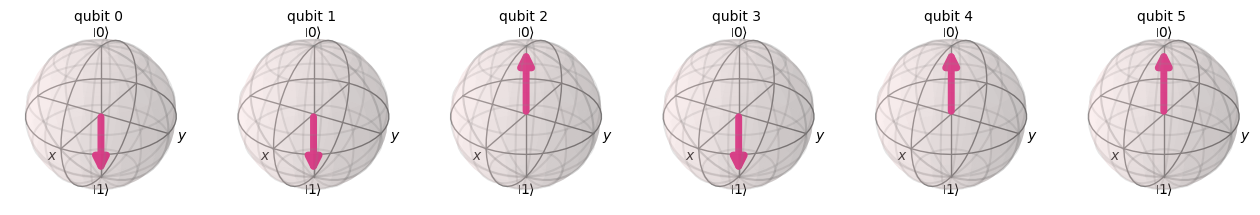

In [203]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

Now that we have converted it to and from the fourier basis, we should test to see if it works using a simulated backend.

In [204]:
def add_measurement(circuit, qubits):
    circuit.barrier()
    for qubit in range(qubits):
        circuit.measure(qubit,qubit)

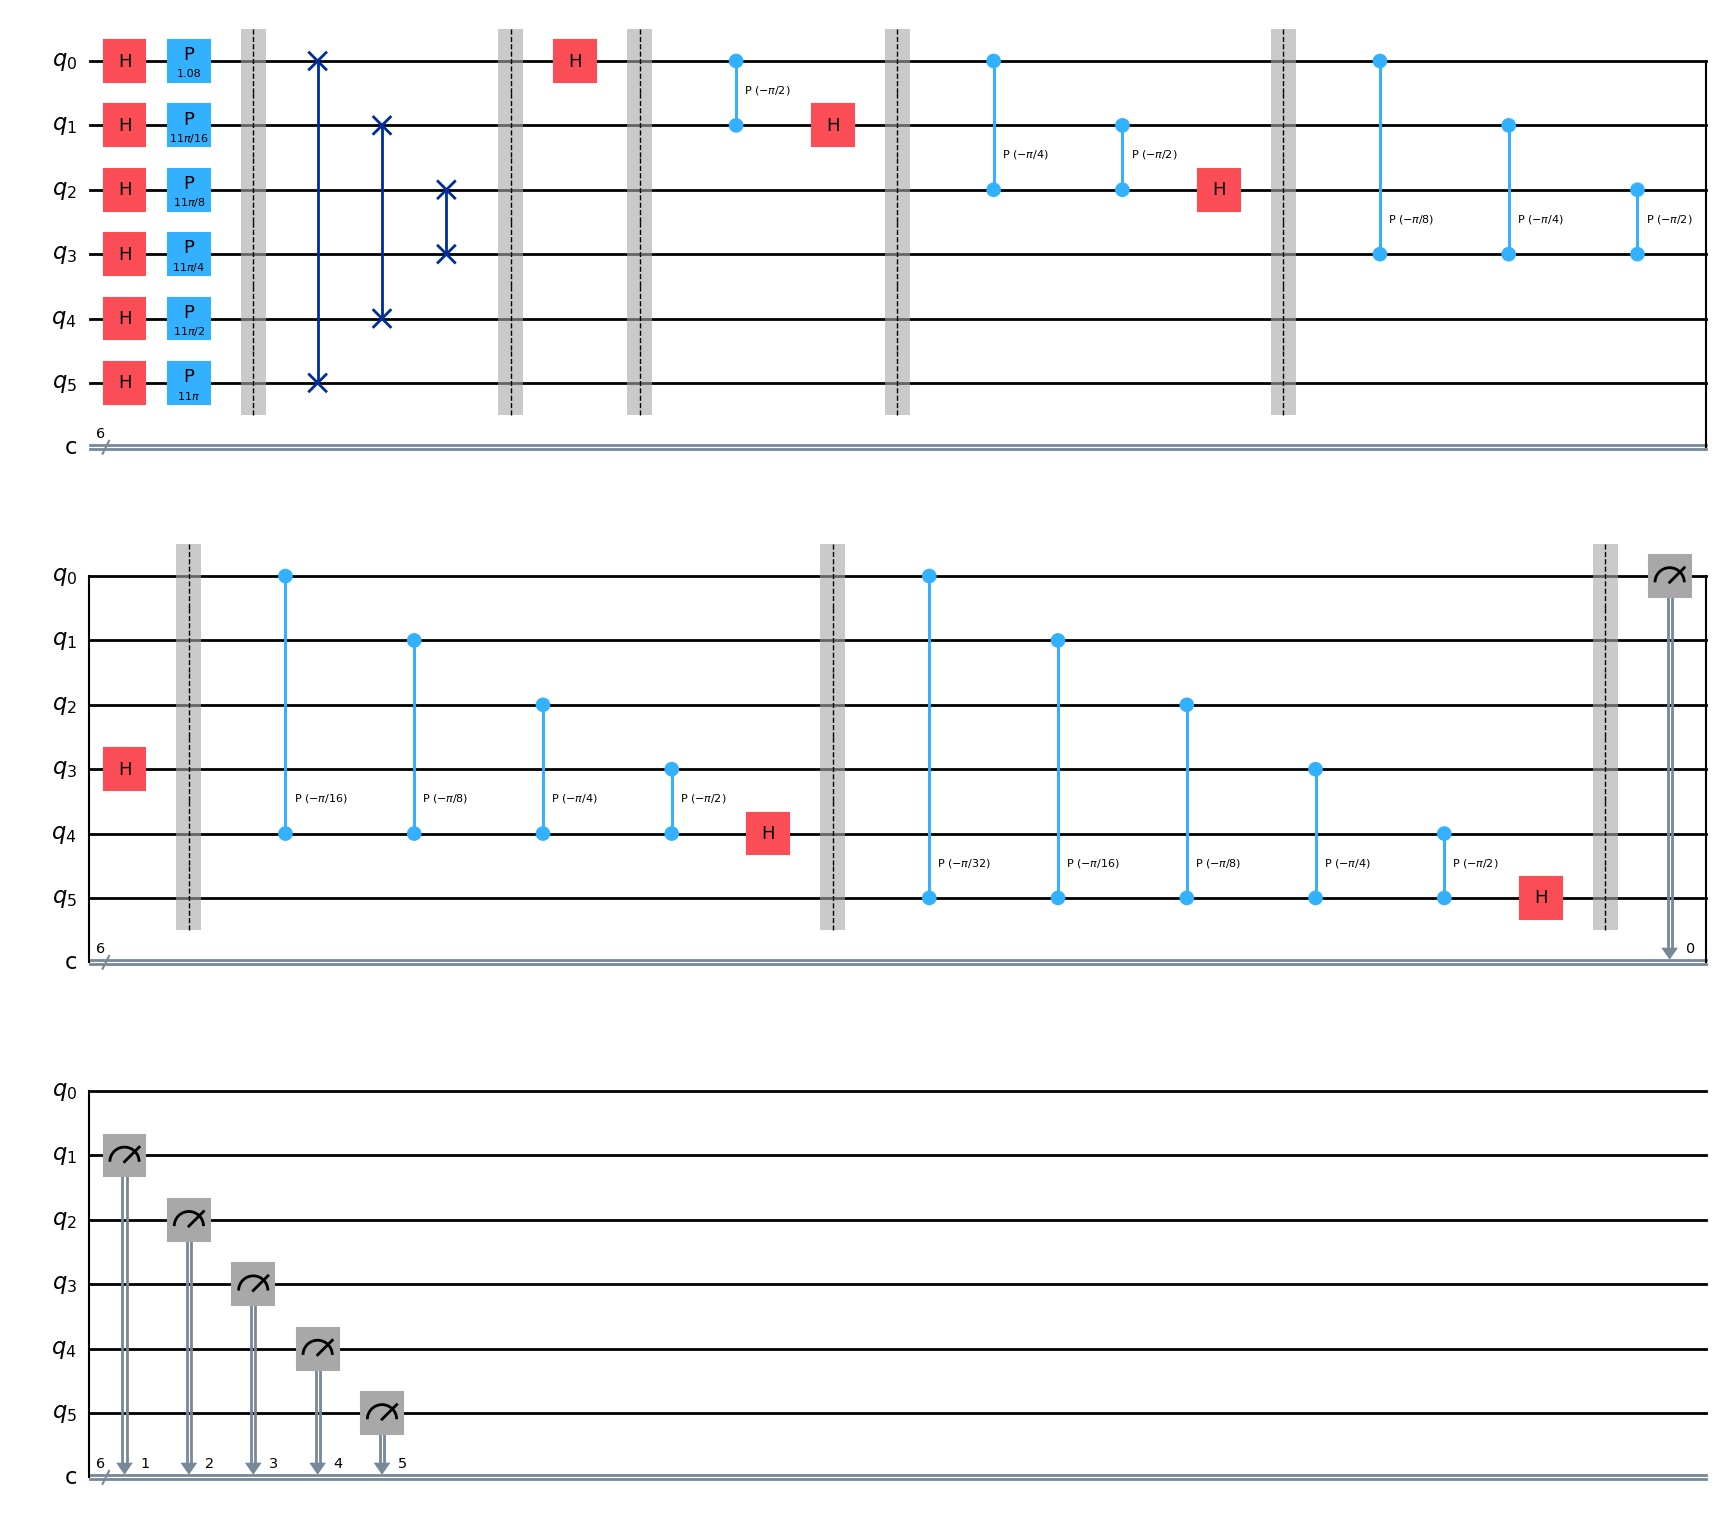

In [ ]:
num_of_shots = 1000
add_measurement(qc, bits)
qc.draw('mpl')

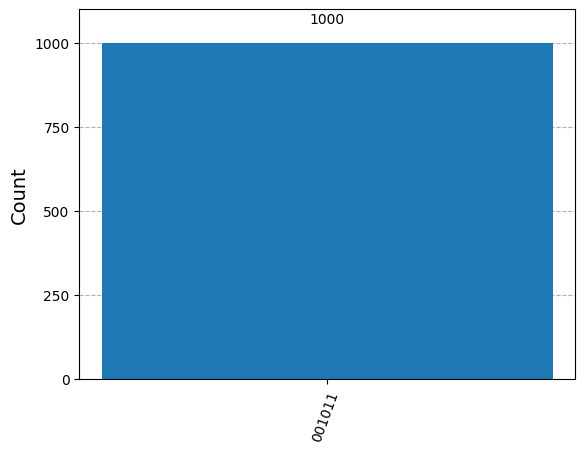

In [207]:
sim = AerSimulator()
transqc = transpile(qc, sim)
result = sim.run(transqc, shots=num_of_shots).result()   
counts = result.get_counts()                    
plot_histogram(counts)

This is the same vector as the input so we have successfully converted to and from the Fourier basis.